In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from FeatureEngineering_2 import *

from joblib import dump, load
from AdvancedModel_helpers import *

In [3]:
# import comet_ml at the top of your file
from comet_ml import Experiment

In [3]:
if not os.path.exists("csv"):
    os.makedirs("csv")
for year in [2016,2017, 2018, 2019]: # 2020 has been excluded to be reserved as the test set
    read_a_season("../nhl_data/",year).to_csv('csv/tidy_{season}.csv'.format(season = year), sep = ',', index = False)

100%|██████████| 6433/6433 [01:05<00:00, 98.80it/s]   


### Consolidating and Sorting CSV Files into a Unified DataFrame

In [522]:
directory = 'csv'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)

    # Filter the DataFrame to only include rows where 5th and 6th digits of 'game_id' are '02' (Regular Season)
    df = df[df['game_id'].astype(str).str[4:6] == '02']

    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
train_val_df = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
train_val_df = train_val_df.sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
train_val_df = train_val_df.reset_index(drop=True)

Loading files: 100%|██████████| 4/4 [00:01<00:00,  2.99file/s]


In [523]:
train_val_df.head(10)

,game_id,event_idx,play_type,shot_type,shot_dist,game_time,goals_home,goals_away,attack_team_name,period,...,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,Rebound,change_shot_angle,Speed,x,y,angle_net,is_goal
0,2016020001,9,Shot,Wrist Shot,13.000000,71,0,0,Toronto Maple Leafs,1,...,11.0,1,17.088007,False,NaN,17.088007,-77.0,5.0,-22.619865,0
1,2016020001,16,Shot,Wrist Shot,13.341664,173,0,0,Ottawa Senators,1,...,-5.0,5,36.715120,False,NaN,7.343024,86.0,13.0,77.005383,0
2,2016020001,23,Shot,Wrist Shot,76.157731,241,0,0,Ottawa Senators,1,...,0.0,18,102.318131,False,NaN,5.684341,23.0,-38.0,-29.931512,0
3,2016020001,25,Shot,Slap Shot,57.974132,286,0,0,Ottawa Senators,1,...,-2.0,19,45.880279,False,NaN,2.414752,33.0,-15.0,-14.995079,0
4,2016020001,38,Shot,Wrist Shot,61.717096,406,0,0,Toronto Maple Leafs,1,...,34.0,16,81.221918,False,NaN,5.076370,-34.0,28.0,-26.980231,0
5,2016020001,40,Shot,Wrist Shot,58.523500,450,0,0,Toronto Maple Leafs,1,...,31.0,23,48.041649,False,NaN,2.088767,-33.0,-17.0,16.886791,0
6,2016020001,43,Goal,Wrist Shot,19.026298,501,0,1,Toronto Maple Leafs,1,...,-8.0,3,17.492856,False,NaN,5.830952,-70.0,1.0,-3.012788,1
7,2016020001,45,Shot,Wrist Shot,56.850682,509,0,1,Toronto Maple Leafs,1,...,0.0,8,57.628118,False,NaN,7.203515,-45.0,-36.0,39.289407,0
8,2016020001,48,Shot,Slap Shot,58.821765,540,0,1,Ottawa Senators,1,...,-22.0,30,102.078401,False,NaN,3.402613,33.0,-18.0,-17.818889,0
9,2016020001,59,Shot,Wrist Shot,58.523500,616,0,1,Ottawa Senators,1,...,22.0,5,35.057096,False,NaN,7.011419,34.0,20.0,19.983107,0


In [4]:
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.calibration import CalibrationDisplay

### Training and Validation sets split

### 1. Train with only **Distance** and **Angle**

In [525]:
# # Create an experiment with your api key
# exp = Experiment(
#     api_key="v5q8O8LftZtvOcoXlVM8Ku8fH",
#     project_name="ift6758",
#     workspace="hfereidouni",
# )

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hfereidouni/ift6758/934d6e4884f046b59408de6197dfa32d



#### 1.1 Training and Validating

In [526]:
train_X_1,train_Y_1,val_X_1,val_Y_1 = split_data(train_val_df,['shot_dist','angle_net'],0.25,True)
train_X_1

,shot_dist,angle_net
205686,54.037024,2.000000
254511,46.529560,28.000000
258329,60.406953,19.000000
215078,54.037024,2.000000
54982,40.804412,36.027373
...,...,...
217653,57.697487,-25.000000
87384,59.008474,0.000000
125109,46.754679,-48.000000
156101,47.801674,37.000000


In [527]:
xgboost1= XGBClassifier()
xgboost1.fit(train_X_1, train_Y_1)
xgboost1_path = './models/xgboost1.joblib'
dump(xgboost1,xgboost1_path)

['./models/xgboost1.joblib']

#### 1.2

##### ROC AUC

{'web': 'https://www.comet.com/api/image/download?imageId=093b3bbb7a744b959333a034ba5d9fe4&experimentKey=934d6e4884f046b59408de6197dfa32d',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=093b3bbb7a744b959333a034ba5d9fe4&experimentKey=934d6e4884f046b59408de6197dfa32d',
 'imageId': '093b3bbb7a744b959333a034ba5d9fe4'}

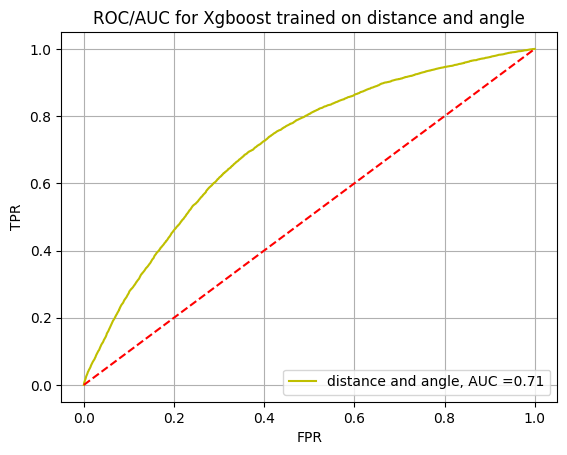

In [528]:
xgboost1=load(xgboost1_path)
val_res = xgboost1.predict_proba(val_X_1)
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_1,val_res,'Xgboost','distance and angle')
# exp.log_figure(figure_name='ROC/AUC Xgboost trained on distance and angle with no hp tuning')

In [529]:
metrics_1 = {
    'class_probabilities':val_res,
    'validation_accuracy': metrics.accuracy_score(xgboost1.predict(val_X_1), val_Y_1),
    'AUC_score':roc_auc_score,
             }
# exp.log_metrics(metrics_1, step=1)

COMET WARNING: Cannot safely convert array([[0.82241225, 0.17758772],
       [0.8434984 , 0.15650159],
       [0.83383596, 0.16616401],
       ...,
       [0.9111359 , 0.0888641 ],
       [0.9218376 , 0.07816235],
       [0.9499217 , 0.05007828]], dtype=float32) object to a scalar value, using its string representation for logging. Resulting string might be invalid


In [530]:
precision_1 = metrics.precision_score(val_Y_1,xgboost1.predict(val_X_1))
recall_1= metrics.recall_score(val_Y_1,xgboost1.predict(val_X_1))

##### Goal rate

In [531]:
probas_and_label = helper_df(val_Y_1,val_res)
probas_and_label

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
25798,0,0.583065,1,0.0,0.000000,99.999324,1.164055e+06,0.000000e+00,0.000000
16073,1,0.583065,2,0.0,0.000000,99.999324,1.164055e+06,0.000000e+00,0.000000
284628,0,0.573995,3,1.0,33.333333,99.995269,1.164055e+06,3.333333e+01,0.002864
77118,1,0.573995,4,1.0,25.000000,99.995269,1.164055e+06,5.833333e+01,0.005011
240356,1,0.573995,5,2.0,40.000000,99.995269,1.164055e+06,9.833333e+01,0.008447
...,...,...,...,...,...,...,...,...,...
172248,0,0.002033,73972,6967.0,9.418429,0.008787,1.164055e+06,1.164018e+06,99.996764
205038,0,0.002033,73973,6967.0,9.418301,0.008787,1.164055e+06,1.164027e+06,99.997573
6850,0,0.002033,73974,6967.0,9.418174,0.008787,1.164055e+06,1.164037e+06,99.998382
288496,0,0.001412,73975,6967.0,9.418047,0.002028,1.164055e+06,1.164046e+06,99.999191


{'web': 'https://www.comet.com/api/image/download?imageId=34cd7bf57b4440b78395cbfdc28fe9c4&experimentKey=934d6e4884f046b59408de6197dfa32d',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=34cd7bf57b4440b78395cbfdc28fe9c4&experimentKey=934d6e4884f046b59408de6197dfa32d',
 'imageId': '34cd7bf57b4440b78395cbfdc28fe9c4'}

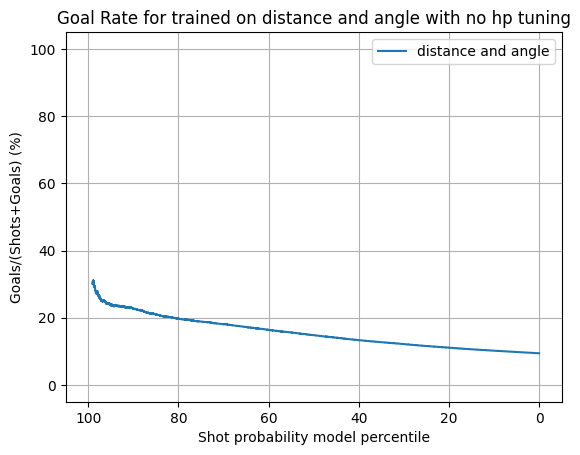

In [532]:
start_length = int(len(probas_and_label)*0.01)
plt.plot(probas_and_label['rank'].iloc[start_length:],probas_and_label['#goal/#goal+#shot'].iloc[start_length:],label="distance and angle")
plt.title(f'Goal Rate for trained on distance and angle with no hp tuning')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
# exp.log_figure(figure_name='Goal Rate for trained on distance and angle with no hp tuning')

{'web': 'https://www.comet.com/api/image/download?imageId=7b6449c0ef574751a6d9663c84ed85fe&experimentKey=934d6e4884f046b59408de6197dfa32d',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=7b6449c0ef574751a6d9663c84ed85fe&experimentKey=934d6e4884f046b59408de6197dfa32d',
 'imageId': '7b6449c0ef574751a6d9663c84ed85fe'}

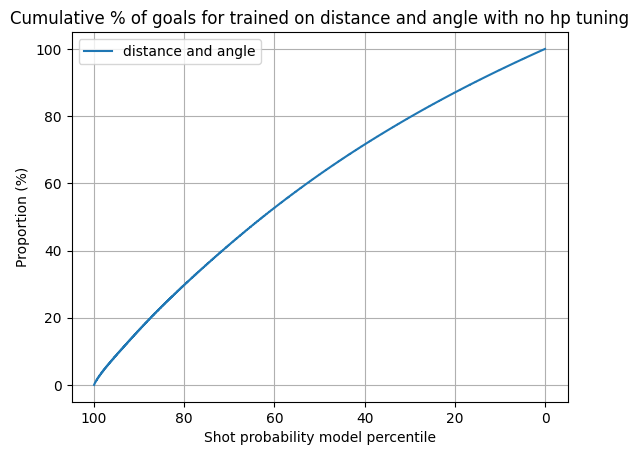

In [533]:
plt.plot(probas_and_label['rank'],probas_and_label['cum_percent'],label="distance and angle")
plt.title(f'Cumulative % of goals for trained on distance and angle with no hp tuning')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
# exp.log_figure(figure_name='Cumulative % of goals for trained on distance and angle with no hp tuning')

{'web': 'https://www.comet.com/api/image/download?imageId=263981789aa94d38b79dc87dd880ccde&experimentKey=934d6e4884f046b59408de6197dfa32d',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=263981789aa94d38b79dc87dd880ccde&experimentKey=934d6e4884f046b59408de6197dfa32d',
 'imageId': '263981789aa94d38b79dc87dd880ccde'}

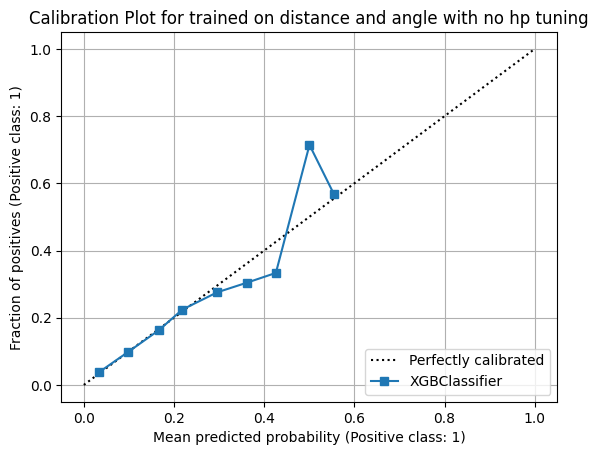

In [534]:
disp = CalibrationDisplay.from_estimator(xgboost1,val_X_1,val_Y_1,n_bins=15)
plt.title("Calibration Plot for trained on distance and angle with no hp tuning")
plt.grid(True)
# exp.log_figure(figure_name="Calibration Plot for trained on distance and angle with no hp tuning")

In [535]:
# exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/hfereidouni/ift6758/934d6e4884f046b59408de6197dfa32d
COMET INFO:   Metrics:
COMET INFO:     AUC_score           : 0.7106202416487704
COMET INFO:     class_probabilities : [[0.82241225 0.17758772]
 [0.8434984  0.15650159]
 [0.83383596 0.16616401]
 ...
 [0.9111359  0.0888641 ]
 [0.9218376  0.07816235]
 [0.9499217  0.05007828]]
COMET INFO:     validation_accuracy : 0.9059019141343139
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     figures          

### 2. Train with **features in part4**

In [536]:
# # Create an experiment with your api key
# exp = Experiment(
#     api_key="v5q8O8LftZtvOcoXlVM8Ku8fH",
#     project_name="ift6758",
#     workspace="hfereidouni",
# )

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hfereidouni/ift6758/1fd819b207ce41e4a09e89e74e45c16e



In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization

In [538]:
train_val_df_2=train_val_df[['game_time','period','x','y','shot_type','last_event_type',
       'x_coord_last_event', 'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'shot_dist','angle_net', 'is_goal']]

##### One hot encoding 

In [539]:
train_val_2_shot_type_oh = onehot_generator(train_val_df_2[['shot_type']])
train_val_2_last_event_type_oh = onehot_generator(train_val_df_2[['last_event_type']])

In [540]:
train_val_df_2= train_val_df_2.drop(columns=['shot_type','last_event_type'])
train_val_df_2 = pd.concat([train_val_df_2,
                       train_val_2_shot_type_oh.set_index(train_val_df_2.index),
                       train_val_2_last_event_type_oh.set_index(train_val_df_2.index)],axis=1)

In [541]:
len(train_val_df)

305814

In [542]:
train_X_2,train_Y_2,val_X_2,val_Y_2 = split_data(train_val_df_2,['game_time', 'period', 'x', 'y', 'x_coord_last_event',
       'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'shot_dist','angle_net', 'shot_type_Backhand', 'shot_type_Deflected',
       'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Tip-In',
       'shot_type_Wrap-around', 'shot_type_Wrist Shot', 'shot_type_nan',
       'last_event_type_Blocked Shot', 'last_event_type_Faceoff',
       'last_event_type_Game Official', 'last_event_type_Giveaway',
       'last_event_type_Goal', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Official Challenge',
       'last_event_type_Penalty', 'last_event_type_Period End',
       'last_event_type_Period Ready', 'last_event_type_Period Start',
       'last_event_type_Shootout Complete', 'last_event_type_Shot',
       'last_event_type_Stoppage', 'last_event_type_Takeaway'],0.25,False)

In [543]:
len(train_X_2.columns)

37

#### Hyperparameter tuning: Bayesian Optimization

###### ref:
######  https://aiinpractice.com/xgboost-hyperparameter-tuning-with-bayesian-optimization/
###### https://zhuanlan.zhihu.com/p/131216861

In [544]:
params = {
    'learning_rate':(0,1),
    'max_depth':(0,100),
    'min_child_weight':(0,10),
    'subsample':(0,1),
    'colsample_bytree': (0,1),
    'gamma':(0,10),
    'eta':(0,1),
    'n_estimators':(50,100)
}

In [545]:
def xgboost_opti(learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,eta,n_estimators):

    xgb = XGBClassifier(learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree= colsample_bytree,
        gamma=gamma,
        eta=eta,
        n_estimators=int(n_estimators))

    cv_score = cross_val_score(xgb,train_X_2,train_Y_2,cv=3,scoring='roc_auc')
    
    return cv_score.mean()

xgb_bo = BayesianOptimization(f=xgboost_opti,pbounds=params,random_state=1)

In [546]:
xgb_bo.maximize()

|   iter    |  target   | colsam... |    eta    |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6917    | 0.417     | 0.7203    | 0.001144  | 0.3023    | 14.68     | 0.9234    | 59.31     | 0.3456    |
| 2         | 0.7265    | 0.3968    | 0.5388    | 4.192     | 0.6852    | 20.45     | 8.781     | 51.37     | 0.6705    |
| 3         | 0.7303    | 0.4173    | 0.5587    | 1.404     | 0.1981    | 80.07     | 9.683     | 65.67     | 0.6923    |
| 4         | 0.7576    | 0.8764    | 0.8946    | 0.8504    | 0.03905   | 16.98     | 8.781     | 54.92     | 0.4211    |
| 5         | 0.7581    | 0.9579    | 0.5332    | 6.919     | 0.3155    | 68.65     | 8.346     | 50.91     | 0.7501    |
| 6         | 0.736     | 0.8268    | 0.7575    | 7.182     | 0.5956    | 67.88     | 8.318     | 51.26     | 0.3354    |
| 7         | 0.7538    

In [547]:
best_param = xgb_bo.max['params']
best_param['n_estimators'] = int(best_param['n_estimators'])
best_param['max_depth'] = int(best_param['max_depth'])
best_param

{'colsample_bytree': 0.709911398651894,
 'eta': 0.8757259843608317,
 'gamma': 5.745398230737068,
 'learning_rate': 0.21271754715887392,
 'max_depth': 66,
 'min_child_weight': 8.744119048167438,
 'n_estimators': 53,
 'subsample': 0.6784461683303725}

In [548]:
xgboost2 = XGBClassifier(**best_param)

In [549]:
xgboost2.fit(train_X_2,train_Y_2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.709911398651894, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.8757259843608317, eval_metric=None, feature_types=None,
              gamma=5.745398230737068, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21271754715887392,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=66, max_leaves=None,
              min_child_weight=8.744119048167438, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=53,
              n_jobs=None, num_parallel_tree=None, ...)

In [550]:
dump(xgboost2,'./models/xgboost2.joblib')


['./models/xgboost2.joblib']

In [551]:
xgboost2_path='./models/xgboost2.joblib'
# exp.log_model('xgboost trained on all features from Q4 and hp tuned',xgboost2_path)
# exp.log_parameters(best_param)

{'web': 'https://www.comet.com/api/image/download?imageId=9a39848ae41d476584d51e092518733a&experimentKey=1fd819b207ce41e4a09e89e74e45c16e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=9a39848ae41d476584d51e092518733a&experimentKey=1fd819b207ce41e4a09e89e74e45c16e',
 'imageId': '9a39848ae41d476584d51e092518733a'}

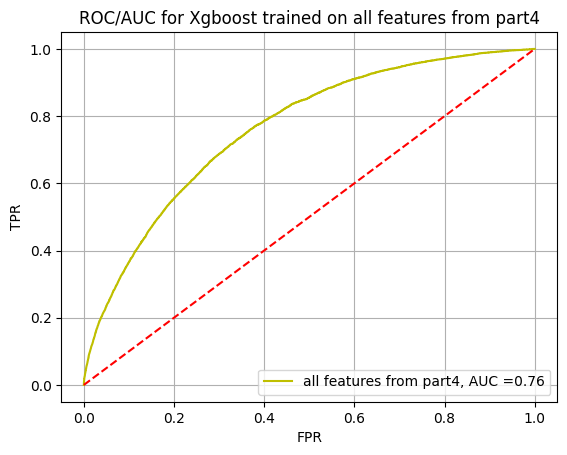

In [552]:
val_res_2 = xgboost2.predict_proba(val_X_2)
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_2,val_res_2,'Xgboost','all features from part4')
# exp.log_figure(figure_name='ROC/AUC Xgboost trained on all features from part4 with hp tuning')

In [553]:
metrics_2 = {
    'class_probabilities':val_res_2,
    'validation_accuracy': metrics.accuracy_score(xgboost2.predict(train_X_2),train_Y_2),
    'AUC_score':roc_auc_score,
             }
# exp.log_metrics(metrics_2, step=1)

COMET WARNING: Cannot safely convert array([[0.9171121 , 0.08288788],
       [0.90865785, 0.09134217],
       [0.764784  , 0.23521605],
       ...,
       [0.9480924 , 0.05190761],
       [0.80176574, 0.19823425],
       [0.921479  , 0.07852104]], dtype=float32) object to a scalar value, using its string representation for logging. Resulting string might be invalid


In [554]:
probas_and_label_2 = helper_df(val_Y_2,val_res_2)
probas_and_label_2

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
116996,1,0.896575,1,0.0,0.000000,100.000000,1.403398e+06,0.000000e+00,0.000000
196821,1,0.879889,2,1.0,50.000000,99.998692,1.403398e+06,5.000000e+01,0.003563
276658,1,0.879306,3,2.0,66.666667,99.997384,1.403398e+06,1.166667e+02,0.008313
165879,1,0.861349,4,3.0,75.000000,99.996076,1.403398e+06,1.916667e+02,0.013657
197977,1,0.851095,5,4.0,80.000000,99.994768,1.403398e+06,2.716667e+02,0.019358
...,...,...,...,...,...,...,...,...,...
234211,0,0.004882,76450,7229.0,9.455853,0.006540,1.403398e+06,1.403360e+06,99.997305
222997,0,0.004846,76451,7229.0,9.455730,0.005232,1.403398e+06,1.403369e+06,99.997979
28883,0,0.004730,76452,7229.0,9.455606,0.003924,1.403398e+06,1.403379e+06,99.998652
295827,0,0.004590,76453,7229.0,9.455482,0.002616,1.403398e+06,1.403388e+06,99.999326


{'web': 'https://www.comet.com/api/image/download?imageId=e4b5e72929544a33a76c025359ddc749&experimentKey=1fd819b207ce41e4a09e89e74e45c16e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=e4b5e72929544a33a76c025359ddc749&experimentKey=1fd819b207ce41e4a09e89e74e45c16e',
 'imageId': 'e4b5e72929544a33a76c025359ddc749'}

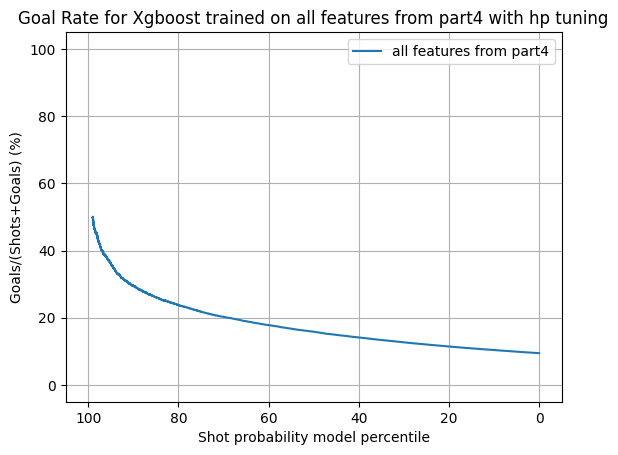

In [555]:
start_length = int(len(probas_and_label_2)*0.01)
plt.plot(probas_and_label_2['rank'].iloc[start_length:],probas_and_label_2['#goal/#goal+#shot'].iloc[start_length:],label="all features from part4")
plt.title(f'Goal Rate for Xgboost trained on all features from part4 with hp tuning')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
# exp.log_figure(figure_name='Goal Rate for Xgboost trained on all features from part4 with hp tuning')

{'web': 'https://www.comet.com/api/image/download?imageId=6bebb229921042338a9570efab443845&experimentKey=1fd819b207ce41e4a09e89e74e45c16e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=6bebb229921042338a9570efab443845&experimentKey=1fd819b207ce41e4a09e89e74e45c16e',
 'imageId': '6bebb229921042338a9570efab443845'}

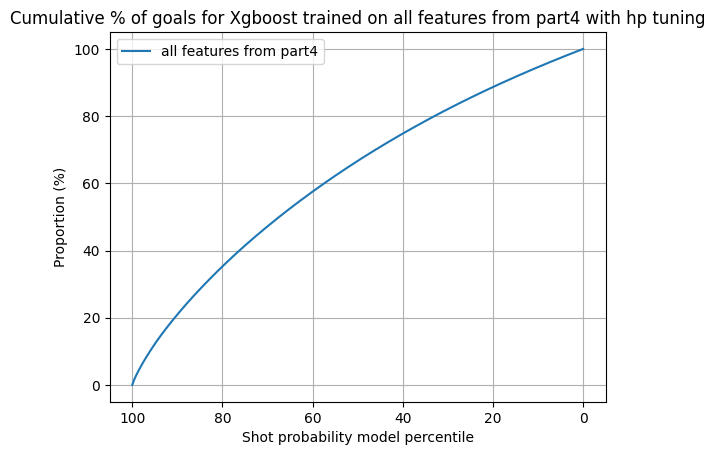

In [556]:
plt.plot(probas_and_label_2['rank'],probas_and_label_2['cum_percent'],label="all features from part4")
plt.title(f'Cumulative % of goals for Xgboost trained on all features from part4 with hp tuning')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
# exp.log_figure(figure_name=f'Cumulative % of goals for Xgboost trained on all features from part4 with hp tuning')

{'web': 'https://www.comet.com/api/image/download?imageId=be8b85f7c59e4f158dbf5333ce991804&experimentKey=1fd819b207ce41e4a09e89e74e45c16e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=be8b85f7c59e4f158dbf5333ce991804&experimentKey=1fd819b207ce41e4a09e89e74e45c16e',
 'imageId': 'be8b85f7c59e4f158dbf5333ce991804'}

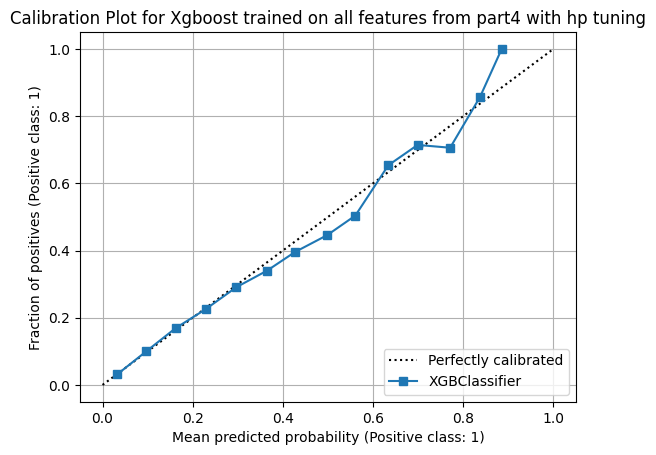

In [557]:
disp = CalibrationDisplay.from_estimator(xgboost2,val_X_2,val_Y_2,n_bins=15)
plt.title("Calibration Plot for Xgboost trained on all features from part4 with hp tuning")
plt.grid(True)
# exp.log_figure(figure_name="Calibration Plot for Xgboost trained on all features from part4 with hp tuning")

In [558]:
# exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/hfereidouni/ift6758/1fd819b207ce41e4a09e89e74e45c16e
COMET INFO:   Metrics:
COMET INFO:     AUC_score           : 0.7625162774569604
COMET INFO:     class_probabilities : [[0.9171121  0.08288788]
 [0.90865785 0.09134217]
 [0.764784   0.23521605]
 ...
 [0.9480924  0.05190761]
 [0.80176574 0.19823425]
 [0.921479   0.07852104]]
COMET INFO:     validation_accuracy : 0.9076299267527032
COMET INFO:   Parameters:
COMET INFO:     alpha                       : 1e-06
COMET INFO:     colsample_bytree            : 0.709911398651894
COMET INFO:     copy_X_train                : True
COMET INFO:     eta                         : 0.87572598436

### 3. Train with **feature selection**

##### ref:
https://scikit-learn.org/stable/modules/feature_selection.html


In [559]:
# Create an experiment with your api key
# exp = Experiment(
#     api_key="v5q8O8LftZtvOcoXlVM8Ku8fH",
#     project_name="ift6758",
#     workspace="hfereidouni",
# )

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hfereidouni/ift6758/3f2c8e5488b04654881315c1c7dca01d



In [6]:
from sklearn.feature_selection import VarianceThreshold,RFE,SelectFromModel
from xgboost import plot_importance

##### a. Filter out low variance features

In [561]:
xgboost2_pretrained = XGBClassifier(**best_param)

In [562]:
t = 0.8*(1-0.8)
selector_1 = VarianceThreshold(t)
values = selector_1.fit_transform(train_X_2)
selector_1.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [563]:
train_X_3_filtered = train_X_2.loc[:,selector_1.get_support()]
val_X_3_filtered = val_X_2.loc[:,selector_1.get_support()]

In [564]:
val_X_3_filtered

,game_time,period,x,y,x_coord_last_event,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,change_shot_angle,Speed,shot_dist,angle_net,shot_type_Wrist Shot,last_event_type_Faceoff
173380,337,1,-88.0,6.0,53.0,-39.0,3,148.006757,NaN,49.335586,6.082763,-80.000000,0,0
145571,1220,3,63.0,-24.0,47.0,23.0,8,49.648766,NaN,6.206096,35.383612,-42.000000,0,0
212619,744,2,82.0,-3.0,47.0,-40.0,9,50.931326,NaN,5.659036,7.615773,-23.000000,1,0
153970,278,3,-69.0,27.0,26.0,16.0,11,95.634722,-45.550405,8.694066,33.600595,-53.000000,1,0
224107,1046,3,66.0,31.0,36.0,-20.0,4,59.169249,NaN,14.792312,38.600518,53.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302897,903,3,-80.0,-1.0,-66.0,-13.0,9,18.439089,NaN,2.048788,9.055385,6.000000,0,0
63705,1119,2,79.0,18.0,39.0,-27.0,12,60.207973,NaN,5.017331,20.591260,60.945396,1,0
100964,87,1,69.0,22.0,34.0,-39.0,7,70.327804,NaN,10.046829,29.732137,47.000000,1,0
86711,710,1,68.0,8.0,80.0,-1.0,1,15.000000,27.194650,15.000000,22.472205,20.000000,1,0


In [565]:
xgboost_3_1 = xgboost2_pretrained.fit(train_X_3_filtered,train_Y_2)

In [566]:
xgboost_3_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.709911398651894, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.8757259843608317, eval_metric=None, feature_types=None,
              gamma=5.745398230737068, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21271754715887392,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=66, max_leaves=None,
              min_child_weight=8.744119048167438, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=53,
              n_jobs=None, num_parallel_tree=None, ...)

In [567]:
val_res_3_1=xgboost_3_1.predict_proba(val_X_3_filtered)[:,1]
auc_3_1 = metrics.roc_auc_score(val_Y_2,val_res_3_1)
auc_3_1

0.7552591076999612

##### b.Recursive Feature Elimination(Wrapper method)

In [568]:
n_feature_in = len(train_X_2.columns)
n_feature_out = len(train_X_3_filtered.columns)

In [569]:
selector_2  = RFE(xgboost2_pretrained, n_features_to_select=n_feature_out, step=1)
selector_2= selector_2.fit(train_X_2,train_Y_2)

In [570]:
train_X_3_rfe = train_X_2.loc[:,selector_2.support_]
val_X_3_rfe = val_X_2.loc[:,selector_2.support_]
train_X_3_rfe

,game_time,period,y,Time_from_the_last_event,Rebound,Speed,shot_dist,angle_net,shot_type_Backhand,shot_type_Slap Shot,shot_type_Wrap-around,shot_type_Wrist Shot,last_event_type_Hit,last_event_type_Stoppage
247975,549,2,3.0,1,True,43.104524,10.440307,16.00000,0,0,0,1,0,0
262354,323,1,33.0,8,False,10.371234,83.773504,23.00000,0,0,0,1,1,0
230890,476,3,-18.0,25,False,2.752744,22.203603,54.00000,0,0,0,0,0,0
62112,749,3,-17.0,1,False,27.586228,25.495098,-41.82017,0,1,0,0,1,0
184360,970,3,-17.0,11,False,4.586181,54.708317,18.00000,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122579,1178,3,-23.0,45,False,3.336961,NaN,0.00000,0,0,0,1,0,0
304137,632,3,31.0,16,False,8.027784,51.400389,37.00000,0,0,0,1,0,0
152315,1011,3,21.0,9,False,2.538591,100.224747,-12.00000,0,0,0,1,0,0
117952,1127,2,-21.0,14,False,5.296321,25.806976,-54.00000,0,0,0,1,0,0


In [571]:
xgboost_3_2 = xgboost2_pretrained.fit(train_X_3_rfe,train_Y_2)

In [572]:
val_res_3_2=xgboost_3_2.predict_proba(val_X_3_rfe)[:,1]
auc_3_2 = metrics.roc_auc_score(val_Y_2,val_res_3_2)
auc_3_2

0.7594013438809146

##### L1-based feature selection

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

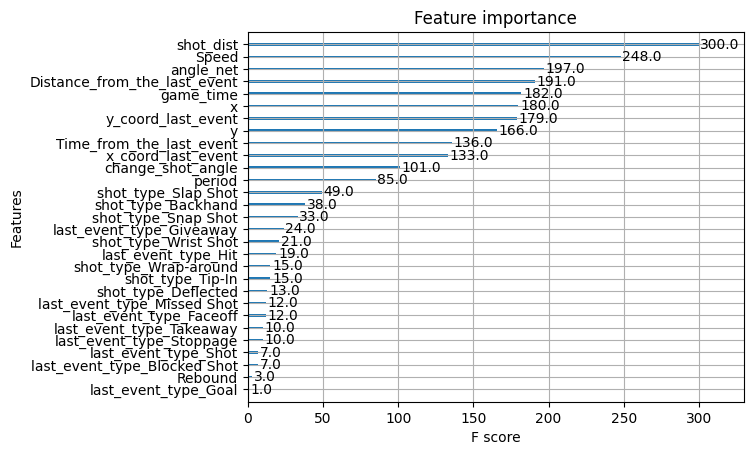

In [573]:
plot_importance(xgboost2)

In [574]:
selector3 = SelectFromModel(xgboost2,prefit=True)

In [575]:
X_new = selector3.fit_transform(train_X_2)

In [576]:
train_X_3_sfm=train_X_2.loc[:,selector3.get_support()]
val_X_3_sfm=val_X_2.loc[:,selector3.get_support()]

In [577]:
len(train_X_3_sfm.columns)

13

In [578]:
xgboost_3_3 = xgboost2_pretrained.fit(train_X_3_sfm,train_Y_2)

In [579]:
val_res_3_3=xgboost_3_3.predict_proba(val_X_3_sfm)[:,1]
auc_3_3 = metrics.roc_auc_score(val_Y_2,val_res_3_3)

In [580]:
auc_3_3

0.7591528213800789

{'web': 'https://www.comet.com/api/image/download?imageId=8f39122baaf8489ba1020df0a3e817fd&experimentKey=3f2c8e5488b04654881315c1c7dca01d',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=8f39122baaf8489ba1020df0a3e817fd&experimentKey=3f2c8e5488b04654881315c1c7dca01d',
 'imageId': '8f39122baaf8489ba1020df0a3e817fd'}

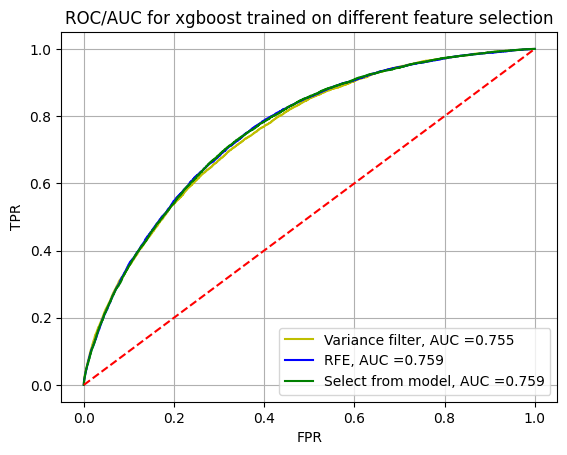

In [581]:
fpr_3_1,tpr_3_1,threshold_3_1 = metrics.roc_curve(val_Y_2,val_res_3_1)
fpr_3_2,tpr_3_2,threshold_3_2 = metrics.roc_curve(val_Y_2,val_res_3_2)
fpr_3_3,tpr_3_3,threshold_3_3 = metrics.roc_curve(val_Y_2,val_res_3_3)

auc_3_1 = metrics.auc(fpr_3_1,tpr_3_1)
auc_3_2 = metrics.auc(fpr_3_2,tpr_3_2)
auc_3_3 = metrics.auc(fpr_3_3,tpr_3_3)

plt.title(f'ROC/AUC for xgboost trained on different feature selection')
plt.plot(fpr_3_1,tpr_3_1,'y',label=f"Variance filter, AUC =%0.3f"%auc_3_1)
plt.plot(fpr_3_2,tpr_3_2,'b',label=f"RFE, AUC =%0.3f"%auc_3_2)
plt.plot(fpr_3_3,tpr_3_3,'g',label=f"Select from model, AUC =%0.3f"%auc_3_3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.grid(True)
plt.legend(loc="lower right")
# exp.log_figure(figure_name='ROC/AUC for xgboost trained on different feature selection')

##### Embedded method is faster and as good as RFE method, we will choose these features and do hyperparam tuning

##### No hyperparameter Tuning

In [582]:
train_X_3_selected = train_X_3_sfm.copy()

In [583]:
xgboost3 = xgboost2_pretrained.fit(train_X_3_selected,train_Y_2)

In [584]:
predict_proba3 = xgboost3.predict_proba(val_X_3_sfm)
val_res_3 = predict_proba3[:,1]

{'web': 'https://www.comet.com/api/image/download?imageId=ca931b8f40234eee949c54977d25a4a0&experimentKey=3f2c8e5488b04654881315c1c7dca01d',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=ca931b8f40234eee949c54977d25a4a0&experimentKey=3f2c8e5488b04654881315c1c7dca01d',
 'imageId': 'ca931b8f40234eee949c54977d25a4a0'}

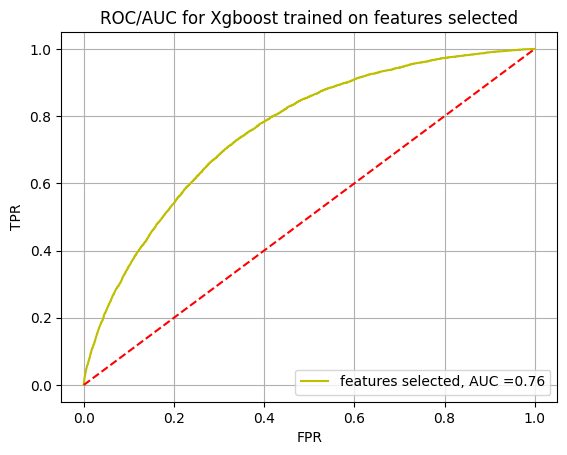

In [585]:
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_2,predict_proba3,'Xgboost','features selected')
# exp.log_figure(figure_name='ROC/AUC for xgboost trained with feature selection no hp tuning')

In [586]:
probas_and_label_3 = helper_df(val_Y_2,predict_proba3)
probas_and_label_3

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
271568,0,0.880312,1,0.0,0.000000,100.000000,1.376090e+06,0.000000e+00,0.000000
116996,1,0.877016,2,0.0,0.000000,99.998692,1.376090e+06,0.000000e+00,0.000000
265069,1,0.842424,3,1.0,33.333333,99.997384,1.376090e+06,3.333333e+01,0.002422
276658,1,0.835794,4,2.0,50.000000,99.996076,1.376090e+06,8.333333e+01,0.006056
276416,1,0.832944,5,3.0,60.000000,99.994768,1.376090e+06,1.433333e+02,0.010416
...,...,...,...,...,...,...,...,...,...
171125,0,0.005682,76450,7229.0,9.455853,0.007848,1.376090e+06,1.376052e+06,99.997251
79393,0,0.005571,76451,7229.0,9.455730,0.005232,1.376090e+06,1.376061e+06,99.997939
157272,0,0.005513,76452,7229.0,9.455606,0.003924,1.376090e+06,1.376071e+06,99.998626
14175,0,0.005379,76453,7229.0,9.455482,0.002616,1.376090e+06,1.376080e+06,99.999313


{'web': 'https://www.comet.com/api/image/download?imageId=fac2bd83efb247b9a75c885b6fdca350&experimentKey=3f2c8e5488b04654881315c1c7dca01d',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=fac2bd83efb247b9a75c885b6fdca350&experimentKey=3f2c8e5488b04654881315c1c7dca01d',
 'imageId': 'fac2bd83efb247b9a75c885b6fdca350'}

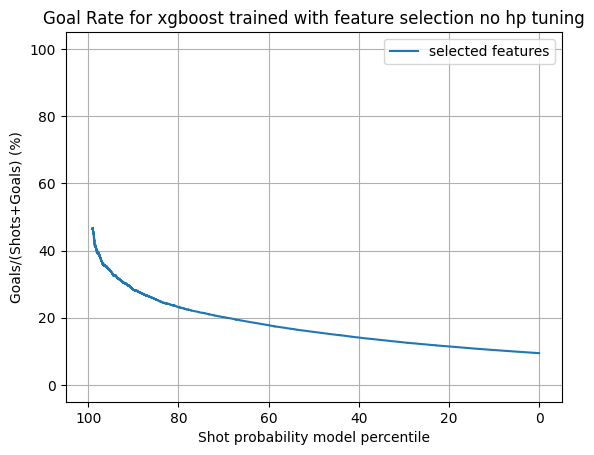

In [587]:
start_length = int(len(probas_and_label_3)*0.01)
plt.plot(probas_and_label_3['rank'].iloc[start_length:],probas_and_label_3['#goal/#goal+#shot'].iloc[start_length:],label="selected features")
plt.title(f'Goal Rate for xgboost trained with feature selection no hp tuning')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
# exp.log_figure(figure_name='Goal Rate for xgboost trained with feature selection no hp tuning')

{'web': 'https://www.comet.com/api/image/download?imageId=3d9f9a9afe3b4c399a23dfd4c79a4c8f&experimentKey=3f2c8e5488b04654881315c1c7dca01d',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=3d9f9a9afe3b4c399a23dfd4c79a4c8f&experimentKey=3f2c8e5488b04654881315c1c7dca01d',
 'imageId': '3d9f9a9afe3b4c399a23dfd4c79a4c8f'}

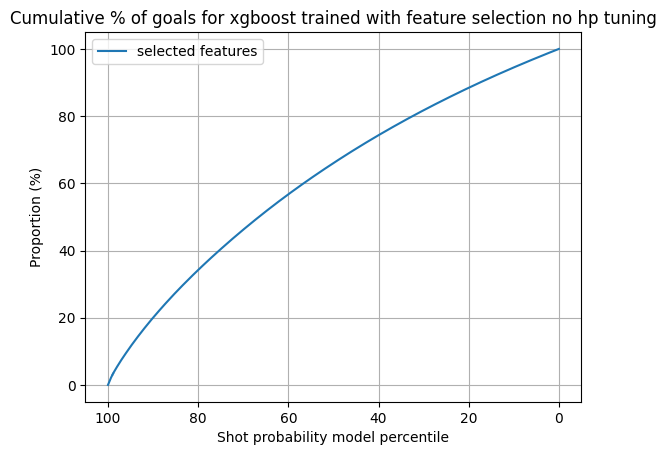

In [588]:
plt.plot(probas_and_label_3['rank'],probas_and_label_3['cum_percent'],label="selected features")
plt.title(f'Cumulative % of goals for xgboost trained with feature selection no hp tuning')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
# exp.log_figure(figure_name=f'Cumulative % of goals for xgboost trained with feature selection no hp tuning')

{'web': 'https://www.comet.com/api/image/download?imageId=1b96e7e2381543f4a7cc218557367405&experimentKey=3f2c8e5488b04654881315c1c7dca01d',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=1b96e7e2381543f4a7cc218557367405&experimentKey=3f2c8e5488b04654881315c1c7dca01d',
 'imageId': '1b96e7e2381543f4a7cc218557367405'}

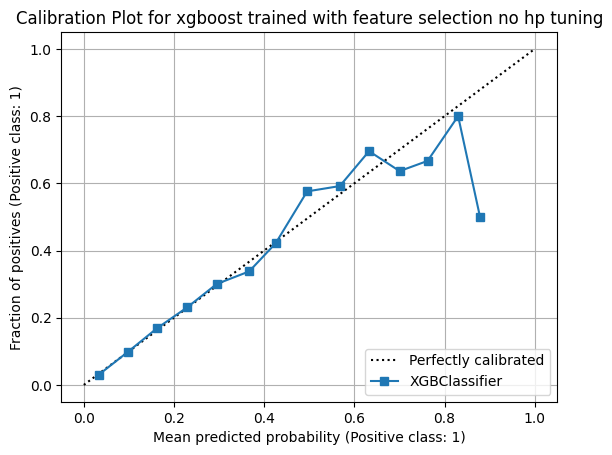

In [589]:
disp = CalibrationDisplay.from_estimator(xgboost3,val_X_3_sfm,val_Y_2,n_bins=15)
plt.title("Calibration Plot for xgboost trained with feature selection no hp tuning")
plt.grid(True)
# exp.log_figure(figure_name=f'Calibration Plot for xgboost trained with feature selection no hp tuning')

In [590]:
dump(xgboost3,'./models/xgboost3.joblib')

['./models/xgboost3.joblib']

In [591]:
xgboost3_path='./models/xgboost3.joblib'
# exp.log_model('xgboost trained with feature selection no hp tuning','./models/xgboost3.joblib')

{'web': 'https://www.comet.com/api/asset/download?assetId=c164e31532134cda89bd200ab8065c3a&experimentKey=3f2c8e5488b04654881315c1c7dca01d',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=c164e31532134cda89bd200ab8065c3a&experimentKey=3f2c8e5488b04654881315c1c7dca01d',
 'assetId': 'c164e31532134cda89bd200ab8065c3a'}

In [592]:
xgboost3 = load('./models/xgboost3.joblib')
val_y_3_filtered_hat = xgboost3.predict(val_X_3_sfm)

In [593]:

metrics_3 = {
    'class_probabilities':val_res_3,
    'validation_accuracy': metrics.accuracy_score(val_y_3_filtered_hat,val_Y_2),
    'AUC_score':roc_auc_score,
             }
# exp.log_metrics(metrics_3, step=1)

COMET WARNING: Cannot safely convert array([0.08428159, 0.11458397, 0.155966  , ..., 0.05004462, 0.19458398,
       0.08620593], dtype=float32) object to a scalar value, using its string representation for logging. Resulting string might be invalid


In [594]:
# exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/hfereidouni/ift6758/3f2c8e5488b04654881315c1c7dca01d
COMET INFO:   Metrics:
COMET INFO:     AUC_score           : 0.7591528213800789
COMET INFO:     class_probabilities : [0.08428159 0.11458397 0.155966   ... 0.05004462 0.19458398 0.08620593]
COMET INFO:     validation_accuracy : 0.9059042038349857
COMET INFO:   Parameters:
COMET INFO:     estimator                          : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.709911398651894, device=None,
              early_stopping_rounds=None, enable_categorical=False,
    

##### With Hyperparameter tuning

In [595]:
# # Create an experiment with your api key
# exp = Experiment(
#     api_key="v5q8O8LftZtvOcoXlVM8Ku8fH",
#     project_name="ift6758",
#     workspace="hfereidouni",
# )

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hfereidouni/ift6758/66775ec9a7af4091b1e29ad6a83b3099



In [596]:
def xgboost_opti_2(learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,eta,n_estimators):

    xgb = XGBClassifier(learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree= colsample_bytree,
        gamma=gamma,
        eta=eta,
        n_estimators=int(n_estimators))

    cv_score = cross_val_score(xgb,train_X_3_sfm,train_Y_2,cv=3,scoring='roc_auc')
    
    return cv_score.mean()

xgb_bo_2 = BayesianOptimization(f=xgboost_opti_2,pbounds=params,random_state=1)

In [597]:
xgb_bo_2.maximize()

|   iter    |  target   | colsam... |    eta    |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7046    | 0.417     | 0.7203    | 0.001144  | 0.3023    | 14.68     | 0.9234    | 59.31     | 0.3456    |
| 2         | 0.7473    | 0.3968    | 0.5388    | 4.192     | 0.6852    | 20.45     | 8.781     | 51.37     | 0.6705    |
| 3         | 0.7451    | 0.4173    | 0.5587    | 1.404     | 0.1981    | 80.07     | 9.683     | 65.67     | 0.6923    |
| 4         | 0.7523    | 0.8764    | 0.8946    | 0.8504    | 0.03905   | 16.98     | 8.781     | 54.92     | 0.4211    |
| 5         | 0.7556    | 0.9579    | 0.5332    | 6.919     | 0.3155    | 68.65     | 8.346     | 50.91     | 0.7501    |
| 6         | 0.7441    | 0.4892    | 0.3886    | 3.636     | 0.09881   | 69.23     | 7.076     | 50.04     | 0.06993   |
| 7         | 0.7429    

In [598]:
best_param_2 = xgb_bo_2.max['params']
best_param_2['n_estimators'] = int(best_param['n_estimators'])
best_param_2['max_depth'] = int(best_param['max_depth'])
best_param_2

{'colsample_bytree': 0.8410967727110894,
 'eta': 0.1535673792004213,
 'gamma': 5.819259318247857,
 'learning_rate': 0.20577862731780183,
 'max_depth': 66,
 'min_child_weight': 7.7866505413773135,
 'n_estimators': 53,
 'subsample': 0.892687568933628}

In [599]:
# exp.log_parameters(best_param_2)

In [600]:
xgboost4 = XGBClassifier(**best_param_2)

In [601]:
xgboost4 = xgboost4.fit(train_X_3_sfm,train_Y_2)

In [602]:
dump(xgboost4,'./models/xgboost4.joblib')
xgboost4_path='./models/xgboost4.joblib'
# exp.log_model('xgboost trained with features selected and hp tuned','./models/xgboost4.joblib')

{'web': 'https://www.comet.com/api/asset/download?assetId=1517fbe063204f32bbe2faa885a8304f&experimentKey=66775ec9a7af4091b1e29ad6a83b3099',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=1517fbe063204f32bbe2faa885a8304f&experimentKey=66775ec9a7af4091b1e29ad6a83b3099',
 'assetId': '1517fbe063204f32bbe2faa885a8304f'}

{'web': 'https://www.comet.com/api/image/download?imageId=c86bf5531c78459298027fa666aa8ec5&experimentKey=66775ec9a7af4091b1e29ad6a83b3099',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=c86bf5531c78459298027fa666aa8ec5&experimentKey=66775ec9a7af4091b1e29ad6a83b3099',
 'imageId': 'c86bf5531c78459298027fa666aa8ec5'}

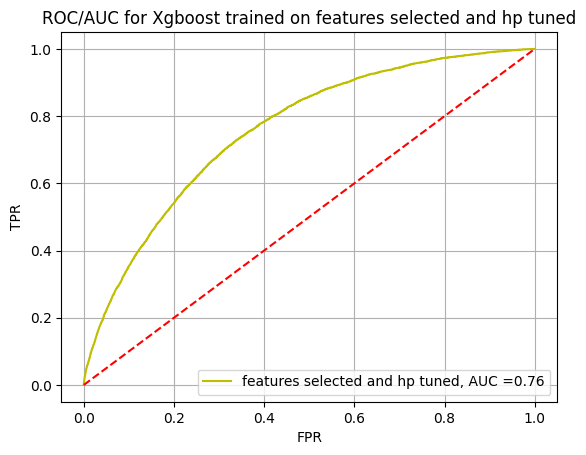

In [603]:
val_res_4 = xgboost3.predict_proba(val_X_3_sfm)
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y_2,val_res_4,'Xgboost','features selected and hp tuned')
# exp.log_figure(figure_name='ROC/AUC for xgboost trained with features selected and hp tuned')

In [604]:
val_y_4_filtered_hat = xgboost4.predict(val_X_3_sfm)
metrics_4 = {
    'class_probabilities':val_res_4,
    'validation_accuracy': metrics.accuracy_score(val_y_4_filtered_hat,val_Y_2),
    'AUC_score':roc_auc_score,
             }
# exp.log_metrics(metrics_4, step=1)

COMET WARNING: Cannot safely convert array([[0.91571844, 0.08428159],
       [0.88541603, 0.11458397],
       [0.844034  , 0.155966  ],
       ...,
       [0.9499554 , 0.05004462],
       [0.805416  , 0.19458398],
       [0.91379404, 0.08620593]], dtype=float32) object to a scalar value, using its string representation for logging. Resulting string might be invalid


In [605]:
probas_and_label_4 = helper_df(val_Y_2,val_res_4)
probas_and_label_4

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
271568,0,0.880312,1,0.0,0.000000,100.000000,1.376090e+06,0.000000e+00,0.000000
116996,1,0.877016,2,0.0,0.000000,99.998692,1.376090e+06,0.000000e+00,0.000000
265069,1,0.842424,3,1.0,33.333333,99.997384,1.376090e+06,3.333333e+01,0.002422
276658,1,0.835794,4,2.0,50.000000,99.996076,1.376090e+06,8.333333e+01,0.006056
276416,1,0.832944,5,3.0,60.000000,99.994768,1.376090e+06,1.433333e+02,0.010416
...,...,...,...,...,...,...,...,...,...
171125,0,0.005682,76450,7229.0,9.455853,0.007848,1.376090e+06,1.376052e+06,99.997251
79393,0,0.005571,76451,7229.0,9.455730,0.005232,1.376090e+06,1.376061e+06,99.997939
157272,0,0.005513,76452,7229.0,9.455606,0.003924,1.376090e+06,1.376071e+06,99.998626
14175,0,0.005379,76453,7229.0,9.455482,0.002616,1.376090e+06,1.376080e+06,99.999313


{'web': 'https://www.comet.com/api/image/download?imageId=c841c07f3c714afc83d8d0c489bddc84&experimentKey=66775ec9a7af4091b1e29ad6a83b3099',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=c841c07f3c714afc83d8d0c489bddc84&experimentKey=66775ec9a7af4091b1e29ad6a83b3099',
 'imageId': 'c841c07f3c714afc83d8d0c489bddc84'}

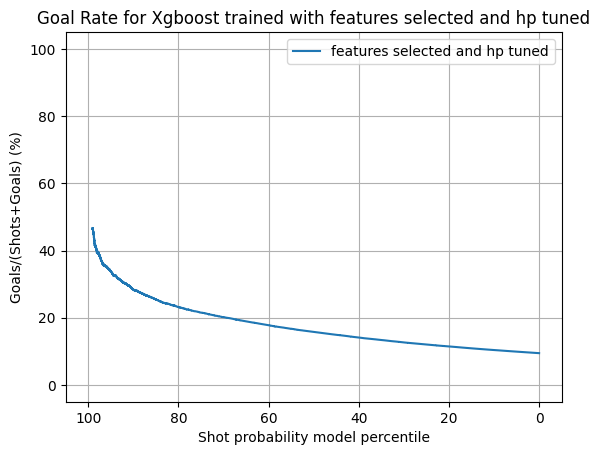

In [606]:
start_length = int(len(probas_and_label_4)*0.01)
plt.plot(probas_and_label_4['rank'].iloc[start_length:],probas_and_label_4['#goal/#goal+#shot'].iloc[start_length:],label='features selected and hp tuned')
plt.title(f'Goal Rate for Xgboost trained with features selected and hp tuned')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
# exp.log_figure(figure_name='Goal Rate for Xgboost trained with features selected and hp tuned')

{'web': 'https://www.comet.com/api/image/download?imageId=ab37aa205caf4f7bba472c8ea462b4c3&experimentKey=66775ec9a7af4091b1e29ad6a83b3099',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=ab37aa205caf4f7bba472c8ea462b4c3&experimentKey=66775ec9a7af4091b1e29ad6a83b3099',
 'imageId': 'ab37aa205caf4f7bba472c8ea462b4c3'}

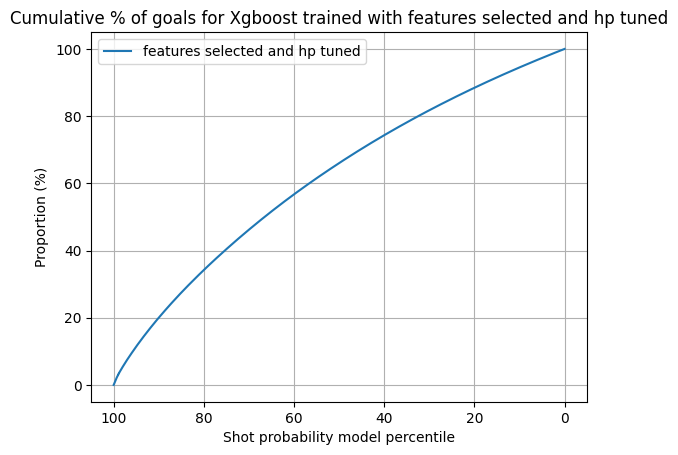

In [607]:
plt.plot(probas_and_label_4['rank'],probas_and_label_4['cum_percent'],label='features selected and hp tuned')
plt.title(f'Cumulative % of goals for Xgboost trained with features selected and hp tuned')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
# exp.log_figure(figure_name=f'Cumulative % of goals for Xgboost trained ith features selected and hp tuned')

{'web': 'https://www.comet.com/api/image/download?imageId=a2831410e9a84250978d5a986e7452e6&experimentKey=66775ec9a7af4091b1e29ad6a83b3099',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=a2831410e9a84250978d5a986e7452e6&experimentKey=66775ec9a7af4091b1e29ad6a83b3099',
 'imageId': 'a2831410e9a84250978d5a986e7452e6'}

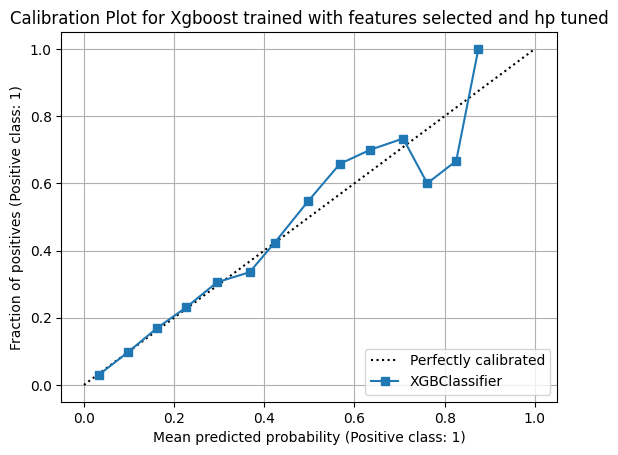

In [608]:
disp = CalibrationDisplay.from_estimator(xgboost4,val_X_3_sfm,val_Y_2,n_bins=15)
plt.title("Calibration Plot for Xgboost trained with features selected and hp tuned")
plt.grid(True)
# exp.log_figure(figure_name="Calibration Plot for Xgboost trained with features selected and hp tuned")

In [609]:
# exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/hfereidouni/ift6758/66775ec9a7af4091b1e29ad6a83b3099
COMET INFO:   Metrics:
COMET INFO:     AUC_score           : 0.7591528213800789
COMET INFO:     class_probabilities : [[0.91571844 0.08428159]
 [0.88541603 0.11458397]
 [0.844034   0.155966  ]
 ...
 [0.9499554  0.05004462]
 [0.805416   0.19458398]
 [0.91379404 0.08620593]]
COMET INFO:     validation_accuracy : 0.9060873204802888
COMET INFO:   Parameters:
COMET INFO:     alpha                       : 1e-06
COMET INFO:     colsample_bytree            : 0.8410967727110894
COMET INFO:     copy_X_train                : True
COMET INFO:     eta                         : 0.1535673792

In [615]:
train_X_3_sfm.columns

Index(['game_time', 'period', 'y', 'Time_from_the_last_event', 'shot_dist',
       'shot_type_Backhand', 'shot_type_Deflected', 'shot_type_Wrap-around',
       'shot_type_Wrist Shot', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Shot',
       'last_event_type_Stoppage'],
      dtype='object')

In [7]:
!pip freeze > requirements.txt